In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
import cPickle as pickle
from scipy import interpolate
from scipy.interpolate import interp1d
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
#from pysynphot import observation
#from pysynphot import spectrum
import forwardmodel
import ciamod

In [2]:
array = pickle.load(open("test_H2H2_H2He_CIA_H2O.pic", "rb")) 
leveltemp = array[0]
levelpress = array[1]
mikespec = np.array([array[2],array[3]],dtype='f')
mikespec[0] = 10000.0 / mikespec[0]
print levelpress.size
print levelpress[79]

80
208.929


In [3]:
mikepress = np.empty(levelpress.size - 1,dtype='float64')
miketemp = np.empty(leveltemp.size -1, dtype='float64')
for i in range(0,mikepress.size):
    mikepress[i] = np.sqrt(levelpress[i] * levelpress[i+1])
mtfit = interp1d(np.log10(levelpress),leveltemp)
miketemp = mtfit(np.log10(mikepress))        
print np.sqrt(levelpress[78] * levelpress[79])
print mikepress.size

190.546
79


In [4]:
x=readsav('../Linelists/xsecarrH2O_1wno_500_10000.save')
inlinelist=x.xsecarr  #3D array with Nwavenubmers x Ntemps x Npressure
inlinetemps=np.asfortranarray(x.t,dtype='float64')
inpress=x.p
inwavenum=x.wno
#print inlinelist.shape
#logpress = np.arange(-5.,2.5,0.125)
#press = 10.**logpress
#print press
linelist = (np.ones([1,79,43,9501],order='F')).astype('float64', order='F')
for i in range (0,42):
    for j in range (0,9500):
        pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
        linelist[0,:,i,j] = np.asfortranarray(pfit(np.log10(mikepress)))
print linelist.shape
print np.result_type(linelist)
press = mikepress*1000.
print press

(1, 79, 43, 9501)
float64
[  1.09647808e-01   1.31825669e-01   1.58489333e-01   1.90546052e-01
   2.29086771e-01   2.75422906e-01   3.31131101e-01   3.98107077e-01
   4.78630041e-01   5.75439888e-01   6.91831054e-01   8.31763900e-01
   1.00000005e+00   1.20226422e+00   1.44543929e+00   1.73780043e+00
   2.08929647e+00   2.51188711e+00   3.01995175e+00   3.63078015e+00
   4.36515687e+00   5.24807349e+00   6.30957261e+00   7.58577557e+00
   9.12010949e+00   1.09647810e+01   1.31825637e+01   1.58489291e+01
   1.90546047e+01   2.29086708e+01   2.75422838e+01   3.31131108e+01
   3.98107097e+01   4.78630029e+01   5.75439930e+01   6.91830814e+01
   8.31763670e+01   1.00000001e+02   1.20226420e+02   1.44543931e+02
   1.73780039e+02   2.08929583e+02   2.51188576e+02   3.01995099e+02
   3.63077998e+02   4.36515719e+02   5.24807334e+02   6.30957246e+02
   7.58577347e+02   9.12010670e+02   1.09647810e+03   1.31825638e+03
   1.58489251e+03   1.90545952e+03   2.29086709e+03   2.75422907e+03
   3.311

In [20]:
#intemp = np.loadtxt("16temps.dat",dtype='float32')
#intemp = np.full(16,1000.,dtype='f')
#inlayer = np.arange(0,15.25,1)  
#layer = np.arange(0,15.00,0.25)
#print layer.size
#tfit = interpolate.splrep(inlayer,intemp,s=0)
#temp = np.asfortranarray(interpolate.splev(layer,tfit, der=0),dtype='float32')
temp = miketemp
w1 = 1.0
w2 = 10.0
logg = 5.0
R2D2 = 1
gasnum = np.asfortranarray(np.array([1],dtype='i'))
print temp

[  270.17970255   272.50772035   274.83572355   277.16372634   279.49174487
   281.81976317   284.14776589   286.47576884   288.80378742   291.26481539
   294.21287613   297.51496851   300.81706323   304.19738762   307.89654588
   311.83631942   315.81236355   320.03643923   324.47230447   328.9081884
   333.34406983   338.10154714   343.29290705   348.59655726   353.90020846
   359.38891615   365.07214308   370.76484631   376.45754805   382.78900119
   389.78808685   396.98326125   404.84996186   413.22096197   421.9106755
   431.35320888   441.9434953    454.05119428   467.15769846   481.15524546
   495.8488159    511.20437724   527.8961241    545.97677483   565.56795997
   586.73520461   609.32250572   633.37588104   659.18972928   686.29690689
   714.75604592   744.7804606    776.24271398   809.40161225   844.73641205
   882.64498192   923.27032037   966.85175568  1013.4028733   1062.93169559
  1114.92297015  1168.35553607  1222.31085205  1275.70904306  1327.6603356
  1378.26707769

In [21]:
VMR1 = np.full((79,),(-4.0)) # water
#vmr2 = np.full((61,),(-3.4)) # ch4
#vmr3 = np.full((61,),(-8.))  # K
#print VMR1.shape
logVMR = np.reshape((VMR1),(1,79))

In [22]:
pcover = 1.0
do_clouds = 0
cloudnum = np.array([1],dtype='i')
#cloudname = np.reshape((cname),(1,1))
cloudrad = np.full((1,79,1),1e-4)
cloudsig = np.full((1,79,1),1e-5)
cloudprof = np.full((1,79,1),0.0)
nwave = 9501

In [23]:
cia, ciatemps = ciamod.read_cia("final1_abel_CIA.dat",inwavenum)
cia = np.asfortranarray(cia, dtype='float32')
ciatemps = np.asfortranarray(ciatemps, dtype='float32')
print cia.shape
print ciatemps.shape
print cia.dtype

(4, 119, 9501)
(119,)
float32


In [28]:
outspec = forwardmodel.marv(w1,w2,temp,logg,R2D2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps)

In [29]:
np.savetxt("disort16stream_test.dat",np.c_[outspec[0,:],outspec[1,:]])

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide


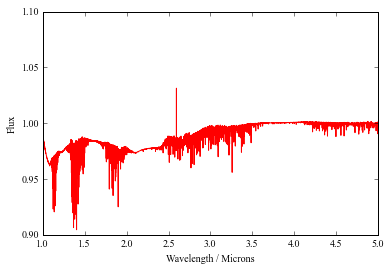

In [31]:
B = np.empty(nwave,dtype='d') 
B = 3.14159274*((2.*6.62606957e-34*(2.99792458e8**2.)) / ((outspec[0,:]*1.e-6)**5.)) / ((np.exp((6.62606957e-34*2.99792458e8)/(outspec[0,:]*1e-6*1.3806488e-23*1000.)))-1.) * 1.e-6
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([1.0, 5.0,0.9,1.1])
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
#plt.plot(outspec[0,:],outspec[1,:],'g-')
#plt.plot(mikespec[0,:],outspec[1,:] / (mikespec[1,:]/1e6),'r-')
plt.plot(mikespec[0,:],((mikespec[1,:] / 1e6) / outspec[1,:]), 'r-')
#plt.plot(outspec[0,:],np.full(nwave,1.0),'b--')

#plt.plot(outspec[0,:],6.666*outspec[1,:],'b-')
plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
plt.savefig('testspec.pdf',format='pdf', dpi=720)

In [11]:
outspec =  outspec[:,np.logical_not(np.logical_or(outspec[0,:] > w2, outspec[0,:] < w1))]
wlen = outspec.shape[1]
wint = outspec[0,0] - outspec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int(round(fwhm / disp))

In [12]:
mikespec[1,:] = mikespec[1,:] / 1e6
mikespec =  mikespec[:,np.logical_not(np.logical_or(mikespec[0,:] > w2, mikespec[0,:] < w1))]
wlen = mikespec.shape[1]
wint = mikespec[0,0] - mikespec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int(round(fwhm / disp))

In [13]:
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel


In [14]:
gauss = Gaussian1DKernel(gwidth)
cspec = convolve(outspec[1,:],gauss,boundary='extend')
spec = np.array([outspec[0,:],cspec])

In [15]:
mgauss = Gaussian1DKernel(gwidth)
mcspec = convolve(mikespec[1,:],mgauss,boundary='extend')
mspec = np.array([mikespec[0,:],mcspec])

In [16]:
print mspec[1]
print spec[1]

[    909.11883545     908.38769531     907.36810303 ...,  186620.921875
  186034.8125      185406.53125   ]
[    908.89880336     908.13043933     907.0674693  ...,  118717.58156636
  103752.58985046   88455.81947768]


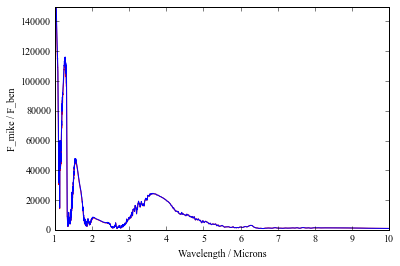

In [17]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([1.0, 10., 0.,1.5e5])
plt.plot(mspec[0,:],mspec[1,:],'r-')
plt.plot(spec[0,:],spec[1,:],'b-')
#plt.plot(spec[0,:],mspec[1,:] / spec[1,:],'g-')
plt.ylabel(r'F_mike / F_ben')
plt.xlabel('Wavelength / Microns')


In [19]:
# now rebin
from pysynphot import observation
from pysynphot import spectrum
wavenew = np.arange(w1,w2,0.0015,dtype='f')
ispec = spectrum.ArraySourceSpectrum(wave=spec[0,:], flux=spec[1,:])
f = np.ones(len(spec[0,:]))
filt = spectrum.ArraySpectralElement(spec[0,:], f, waveunits='microns')
obs = observation.Observation(ispec, filt, binset=wavenew, force='taper')

ImportError: No module named pysynphot

In [ ]:
unc = np.max(obs.binflux)
error = np.full(500,unc/50)
outflux = np.ones(500)
outflux = obs.binflux + error*np.random.randn(500)
    

In [ ]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.8, 2.5, 0.,50])
plt.plot(outspec[0,:],outspec[1,:],'r-')
plt.plot(spec[0,:],spec[1,:],'b-')
plt.plot(wavenew,outflux,'b-')
plt.ylabel(r'$Flux$')
plt.xlabel('Wavelength / Microns')


In [ ]:
np.savetxt('sim_spectrum.dat', np.c_[wavenew,outflux,error])

In [ ]:
gwidth = 4
if (gwidth % 2 == 0):
    gwidth = gwidth + 1

In [ ]:
print gwidth

In [ ]:
theta = [-3.45, -3.40]
fixvmr = -8.

In [ ]:
test = np.array([theta[0],theta[1], fixvmr]).reshape(3,)
print test